In [2]:
import pandas as pd
from datetime import datetime

In [3]:
!pip install kaleido

Defaulting to user installation because normal site-packages is not writeable


In [4]:
simpsons_episodes = pd.read_pickle("./data/simpsons_processed.pkl")

In [5]:
simpsons_episodes.head()

season  episode                               title    airdate rating  \
0       1        1   Simpsons Roasting on an Open Fire 1989-12-17    8.1   
1       1        2                     Bart the Genius 1990-01-14    7.6   
2       1        3                     Homer's Odyssey 1990-01-21    7.3   
3       1        4       There's No Disgrace Like Home 1990-01-28    7.6   
4       1        5                    Bart the General 1990-02-04    7.9   

   total_votes                                               desc  \
0         8400  Homer is forced to become a department store S...   
1         5700  Bart ends up at a school for gifted children a...   
2         5000  After losing his job, Homer contemplates endin...   
3         4900  After being embarrassed by the rest of the fam...   
4         5300  After being beaten up by Nelson Muntz one too ...   

                          director                           writer prod_code  \
0                [David Silverman]                      [Mimi Pond]      7G08   
1                [David Silverman]                      [Jon Vitti]      7G02   
2                     [Wes Archer]  [Jay Kogen, Wallace Wolodarsky]      7G03   
3  [Kent Butterworth, Gregg Vanzo]            [Al Jean, Mike Reiss]      7G04   
4                [David Silverman]              [John Swartzwelder]      7G05   

  viewers  ep_overall  As_Themselves  Character_Played  Homer_main  \
0    26.7           1              0                 0           1   
1    24.5           2              0                 0           0   
2    27.5           3              0                 1           1   
3    20.2           4              0                 0           1   
4    27.1           5              0                 0           0   

   Marge_main  Bart_main  Lisa_main  Maggie_main  Treehouse  
0           1          1          0            0          0  
1           0          1          0            0          0  
2           0          0          0            0          0  
3           0          0          0            0          0  
4           0          1          0            0          0

Data dictionary
- **season**: Season that the episode appears in.
- **episode**: Episode number within the respective season.
- **title**: Title of the episode (according to IMDb).
- **airdate**: Original airdate of the episode (in the US).
- **rating**: Average rating (out of 10) given to the episode by users of IMDb.
- **total_votes**: Total number of ratings on IMDb used to calculate the average rating.
- **desc**: The provided synopsis given for the episode.
- **director**: The director (or directors) for the episode; is in list format.
- **writer**: The writer (or writers) of the episode; is in list format.
- **prod_code**: The production code used for the episode.
- **viewers**: The number of viewers (of original US airing) of the episode in millions.
- **ep_overall**: The overall episode number (so episode number factoring in all previous seasons).
- **As_Themselves**: A flag which indicates whether any celebrity guest stars appeared in episode (credited as Himself/Herself/Themselves/Narrator).
- **Character_Played**: A flag which indicates whether any celebrity guest stars appeared in episode (as a named character).
- **Homer_main**: Homer was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Marge_main**: Marge was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Bart_main**: Bart was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Lisa_main**: Lisa was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Maggie_main**: Maggie was mentioned in either the episode title or description (and so is considered a main/featured character for analysis purposes).
- **Treehouse**: This is a `Treehouse of Horror` episode.

In [6]:
print(f"Highest rated episode has a score of {simpsons_episodes.rating.max()}")
print(f"Lowest rated episode has a score of {simpsons_episodes.rating.min()}")

Highest rated episode has a score of 9.3
Lowest rated episode has a score of 4.0


# Split scores up between
- Above 8.5
- Above 7.5
- Above 6.5
- Above 5.5
- Less than 5.5

In [7]:
def convert_rating(rating):
    if rating >= 8.5:
        output = 1
    elif rating >= 7.5:
        output = 2
    elif rating >= 6.5:
        output = 3
    elif rating >= 5.5:
        output = 4
    else:
        output = 5
    
    return output

In [8]:
simpsons_episodes.rating = simpsons_episodes.rating.astype('float')
simpsons_episodes.viewers = simpsons_episodes.viewers.astype('float')

In [9]:
simpsons_episodes['rating_group'] = simpsons_episodes.rating.apply(convert_rating)
simpsons_episodes['votes_k'] = simpsons_episodes.total_votes.apply(lambda x: x/1000)
simpsons_episodes['title'] = simpsons_episodes.title.apply(lambda x: x.strip())
simpsons_episodes['date_format'] = simpsons_episodes.airdate.apply(lambda x: x.strftime("%a %d %b %Y"))

# Other summaries?

Writers:

- How many episodes is each person credited to?
- What was the average rating of a writers episodes?
- Who did a writer mainly focus on (e.g. which member of the simpsons family features most often in their episodes?)
    - In particular, look out for any writer who has a much higher percentage for a specific character (instead of just... writer X wrote one more episode about Bart etc.)

Treehouse of Horror:
- Any particular writers or directors that work on these episodes a lot?
- How do these episodes compare rating/viewers wise to the rest of the season (or the season average)

Guest Stars:
- Does adding a guest star generally improve the ratings/viewership of an episode?

# BERTopic

Using the episode title and description, what topics does BERTopic produce?
- Plot these topics in 3D for visualization
- What do these topics generally represent?
- What are the average ratings/viewerships of these topics?

## Chord Chart

- Show interaction between cast members (for featured episodes).
- E.g. how often did each family member share the spotlight in an episode)

# Episode Rating Breakdown

In [10]:
import plotly.graph_objects as go
import numpy as np

In [11]:
# There is an episode (S28E12&13) that is actually a two parter. Therefore, duplicate the details (but add part 1 and 2 to title)

mask1 = (simpsons_episodes.season==28)
mask2 = (simpsons_episodes.episode==12)
two_parter = simpsons_episodes[mask1 & mask2].copy()
simpsons_episodes['title'] = np.where(mask1 & mask2, "The Great Phatsby (part 1)", simpsons_episodes['title'])
two_parter.title = "The Great Phatsby (part 2)"
two_parter.episode = 13
simpsons_episodes_full = pd.concat([simpsons_episodes, two_parter])
simpsons_episodes_full.reset_index(drop=True, inplace=True)

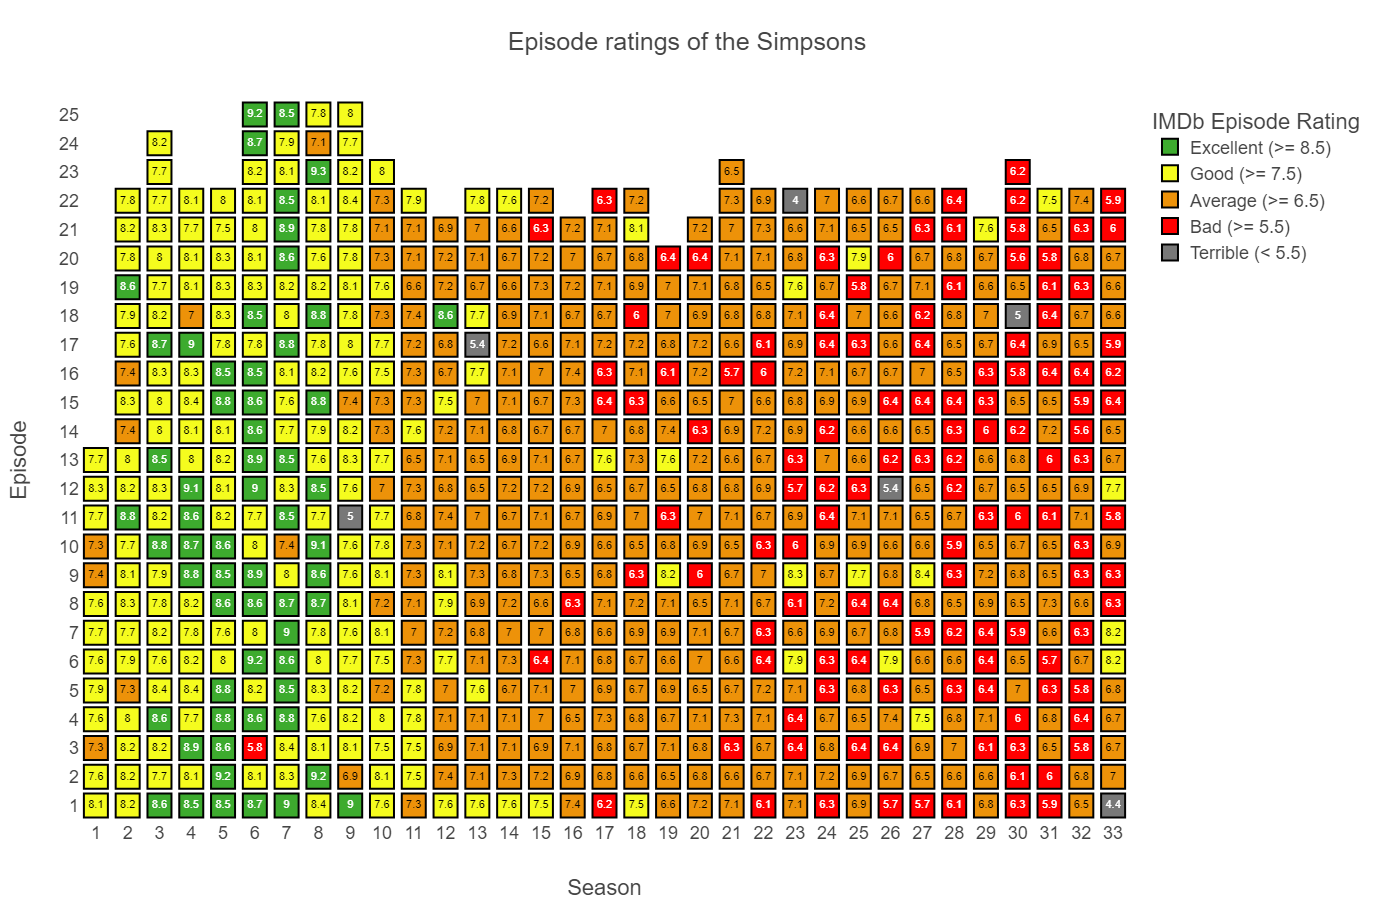

In [12]:
fig = go.Figure()

rating_groups = ['Excellent (>= 8.5)', 'Good (>= 7.5)', 'Average (>= 6.5)', 'Bad (>= 5.5)', 'Terrible (< 5.5)']
rating_color = ['rgb(61, 171, 46)', 'rgb(245, 252, 30)', 'rgb(237, 146, 9)', 'rgb(255, 0, 0)', 'rgb(120, 120, 120)']
text_color = ['white', 'black', 'black', 'white', 'white']

config = {'displayModeBar': False}

for i in range(1,6):
    selection = simpsons_episodes_full[simpsons_episodes_full.rating_group == i]
    
    fig.add_trace(
        go.Scatter(
            x=selection.season, y=selection.episode,
            name=rating_groups[i-1],
            mode='markers+text',
            text=selection.rating,
            textposition='middle center',
            textfont = dict(
                family = "arial",
                color=text_color[i-1],
                size = 11
            ),
            marker_color=rating_color[i-1],
            customdata = selection[['season', 'episode', 'title', 'rating', 'date_format', 'votes_k']],
            hovertemplate="<br>".join([
                "<b>%{customdata[2]}</b><br>",
                "<b>Season %{customdata[0]} - Episode %{customdata[1]}</b>",
                "<b>Original Airdate:</b> %{customdata[4]}",
                "<b>IMDb Rating: %{customdata[3]:.1f}</b> (%{customdata[5]:.1f}k votes)",
                "<extra></extra>",
            ]),
    ))
    
fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Episode ratings of the Simpsons",
    width=1300,
    height=900,
    showlegend=True,
    xaxis_title="Season",
    yaxis_title="Episode",
    template="none",#"simple_white",
    legend_title_text='IMDb Episode Rating'
)

fig.update_traces(
    marker=dict(size=24, symbol="square", line=dict(width=2, color="Black")),
    selector=dict(mode="markers+text"),
)

fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=False, fixedrange=True)
fig.update_yaxes(range=[0.5, 25.5], tick0=1, dtick=1, showgrid=False, fixedrange=True)

    
fig.show(config=config)

In [13]:
fig.write_html("./img/simpsons_episode_rating.html", include_plotlyjs='cdn')

In [14]:
fig.write_image("./img/simpsons_episode_rating.png")

# Season Summaries

- How many episodes features each family member as the 'main'?
- What was the average rating of each season?
- What was the average viewership of each season?
- How many of each type of guest star feature in each season?
- How many total guest stars appear in a season?
- What was the highest rated episode each season? Any commonality between them?

- Any correlation between the above figures?

In [15]:
simpsons_episodes['guest'] = simpsons_episodes.As_Themselves + simpsons_episodes.Character_Played
simpsons_episodes['guest_flag'] = simpsons_episodes.guest.apply(lambda x: 1 if x>0 else 0)
simpsons_episodes['ep_count'] = 1
agg_functions = {'season': 'first', 'rating': 'mean', 'viewers': 'mean',
                 'As_Themselves': 'sum', 'Character_Played': 'sum', 'guest': 'mean',
                 'Homer_main': 'mean', 'Marge_main': 'mean', 'Bart_main': 'mean',
                 'Lisa_main': 'mean', 'Maggie_main': 'mean', 'guest_flag': 'sum',
                'ep_count': 'sum'}
simpsons_season = simpsons_episodes.groupby(simpsons_episodes['season']).aggregate(agg_functions)

simpsons_season.rating = simpsons_season.rating.round(2)
simpsons_season.viewers = simpsons_season.viewers.round(2)
simpsons_season['guest_count'] = simpsons_season.As_Themselves + simpsons_season.Character_Played

In [16]:
simpsons_season.head()

season  rating  viewers  As_Themselves  Character_Played     guest  \
season                                                                       
1            1    7.68    27.81              0                 6  0.461538   
2            2    7.98    24.40              5                13  0.818182   
3            3    8.15    21.77             16                 8  1.000000   
4            4    8.26    22.40             17                 6  1.045455   
5            5    8.33    18.91             12                 6  0.818182   

        Homer_main  Marge_main  Bart_main  Lisa_main  Maggie_main  guest_flag  \
season                                                                          
1         0.538462    0.307692   0.461538   0.153846     0.000000           5   
2         0.681818    0.136364   0.454545   0.181818     0.045455          12   
3         0.708333    0.166667   0.500000   0.250000     0.041667          11   
4         0.727273    0.363636   0.545455   0.454545     0.090909          14   
5         0.545455    0.181818   0.454545   0.045455     0.045455          11   

        ep_count  guest_count  
season                         
1             13            6  
2             22           18  
3             24           24  
4             22           23  
5             22           18

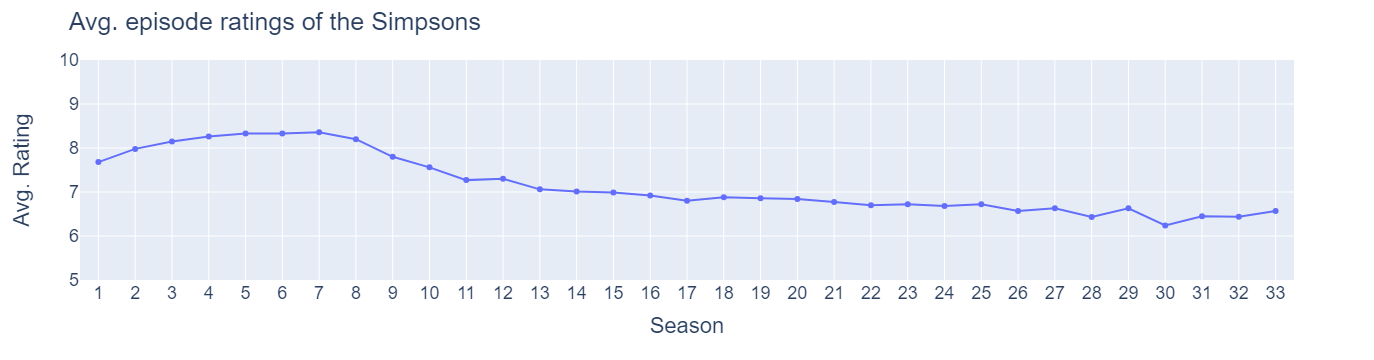

In [17]:
import plotly.express as px
fig = px.line(simpsons_season, x='season', y='rating', markers=True)
fig.update_yaxes(range=[5, 10])

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. episode ratings of the Simpsons",
    xaxis_title="Season",
    yaxis_title="Avg. Rating",
)

fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=True, fixedrange=False)

fig.show()

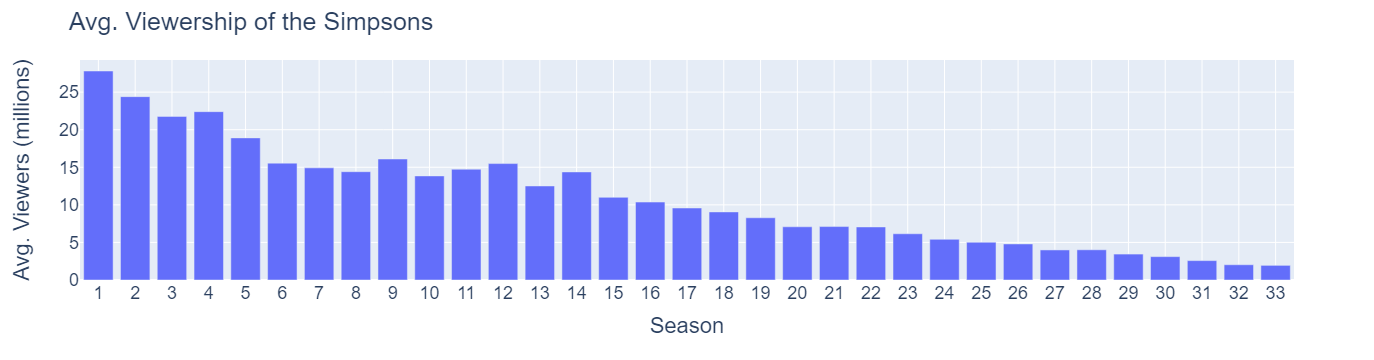

In [18]:
fig = px.bar(simpsons_season, x='season', y='viewers')

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. Viewership of the Simpsons",
    xaxis_title="Season",
    yaxis_title="Avg. Viewers (millions)"
)
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1, showgrid=True)

fig.show()

In [19]:
# Plot the viewership for the treehouse of horror episode again the season average
# Also plot these figures for the season premier
treehouse_episodes = simpsons_episodes[simpsons_episodes.Treehouse == 1]
first_episodes = simpsons_episodes[simpsons_episodes.episode == 1]
print(treehouse_episodes.shape)
print(first_episodes.shape)

(32, 26)
(33, 26)


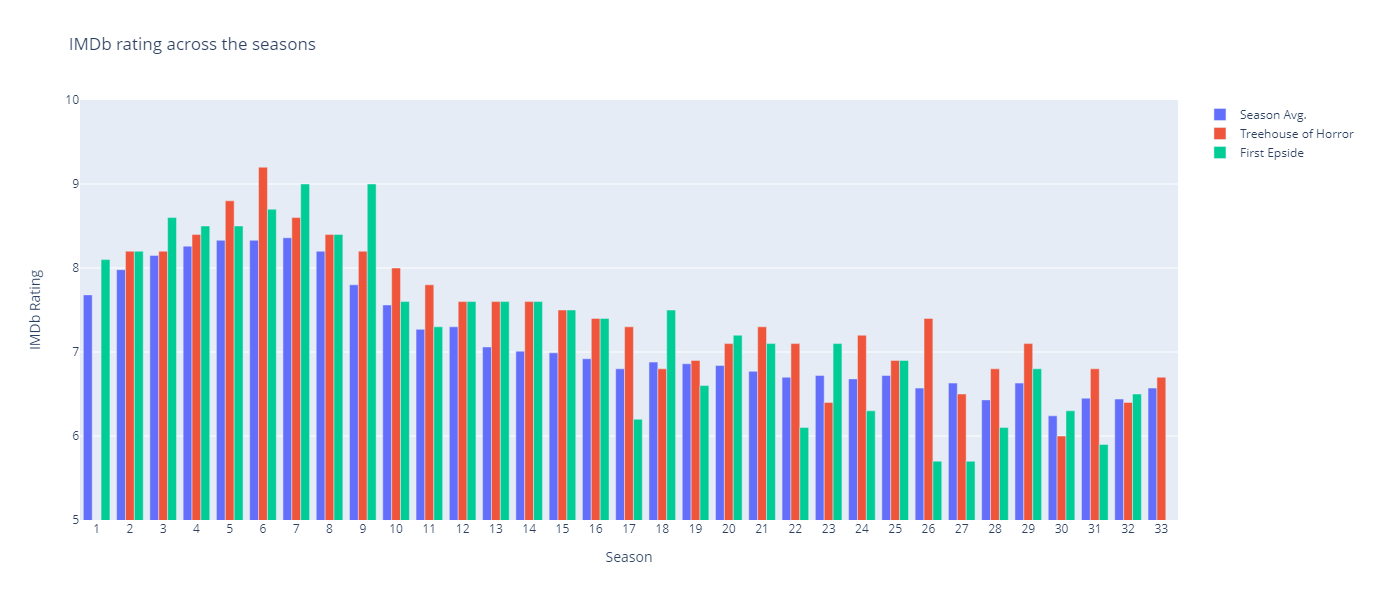

In [20]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Season Avg.', x=simpsons_season.season, y=simpsons_season.rating),
    go.Bar(name='Treehouse of Horror', x=treehouse_episodes.season, y=treehouse_episodes.rating),
    go.Bar(name='First Epside', x=first_episodes.season, y=first_episodes.rating),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
fig.update_yaxes(range=[5, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=600,
    xaxis_title='Season',
    yaxis_title='IMDb Rating',
    title='IMDb rating across the seasons'
)
fig.show()

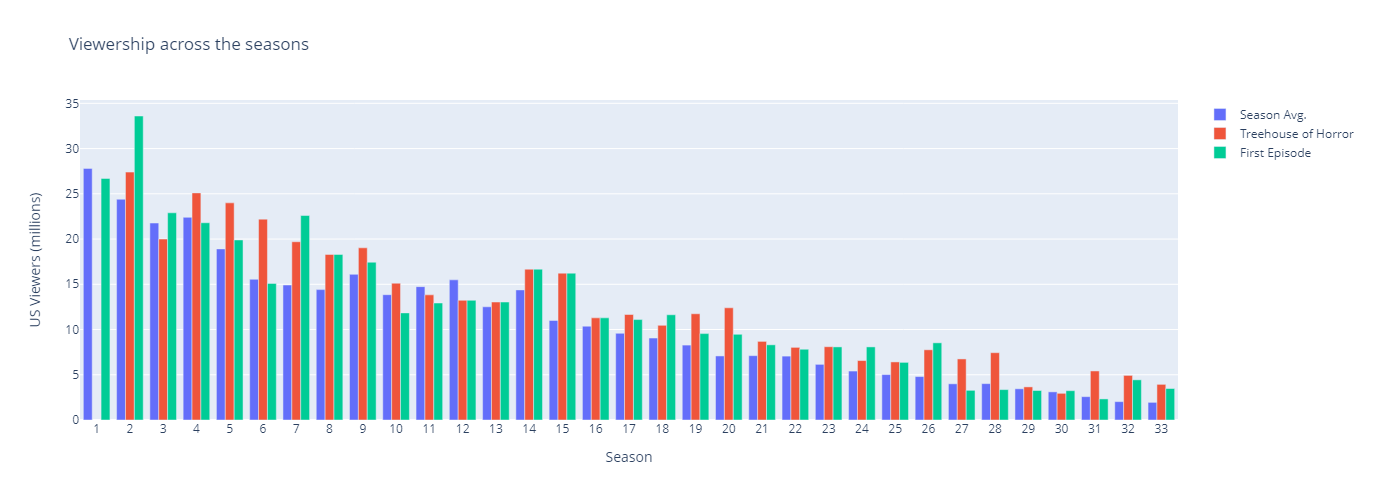

In [50]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Season Avg.', x=simpsons_season.season, y=simpsons_season.viewers),
    go.Bar(name='Treehouse of Horror', x=treehouse_episodes.season, y=treehouse_episodes.viewers),
    go.Bar(name='First Episode', x=first_episodes.season, y=first_episodes.viewers),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='US Viewers (millions)',
    title='Viewership across the seasons'
)
fig.show()

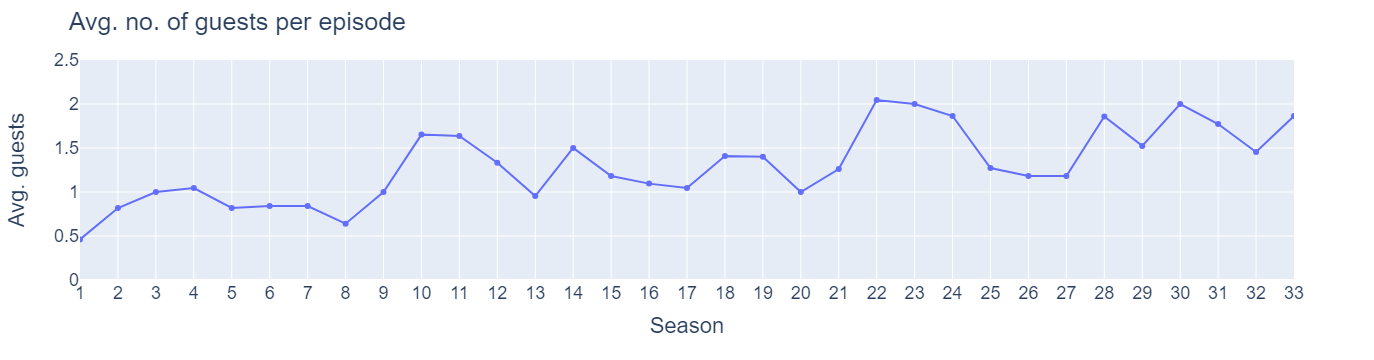

In [22]:
fig = px.line(simpsons_season, x='season', y='guest', markers=True)

fig.update_layout(
    font_family="Arial",
    font_size=18,
    title="Avg. no. of guests per episode",
    xaxis_title="Season",
    yaxis_title="Avg. guests"
)
fig.update_xaxes(range=[1, 33], tick0=1, dtick=1)
fig.update_yaxes(range=[0, 2.5])

fig.show()

In [23]:
# Bar chart of no. of episodes with a guest against episodes without
# Then go on to shown average rating/viewership for guest episodes (and non-guest)

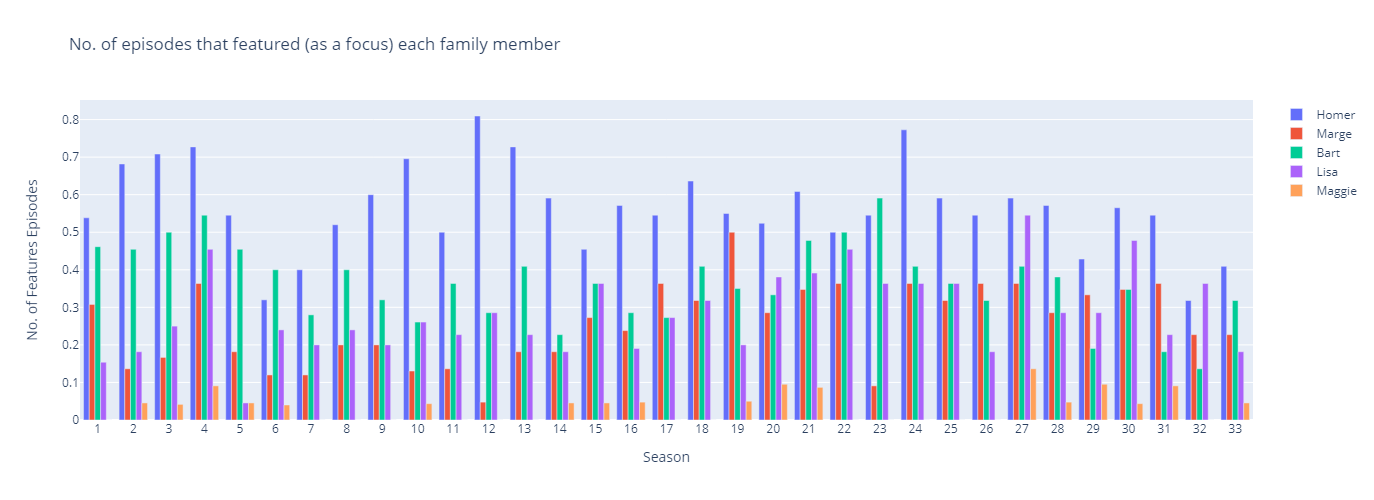

In [24]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Homer', x=simpsons_season.season, y=simpsons_season.Homer_main),
    go.Bar(name='Marge', x=simpsons_season.season, y=simpsons_season.Marge_main),
    go.Bar(name='Bart', x=simpsons_season.season, y=simpsons_season.Bart_main),
    go.Bar(name='Lisa', x=simpsons_season.season, y=simpsons_season.Lisa_main),
    go.Bar(name='Maggie', x=simpsons_season.season, y=simpsons_season.Maggie_main),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='No. of Features Episodes',
    title='No. of episodes that featured (as a focus) each family member'
)
fig.show()

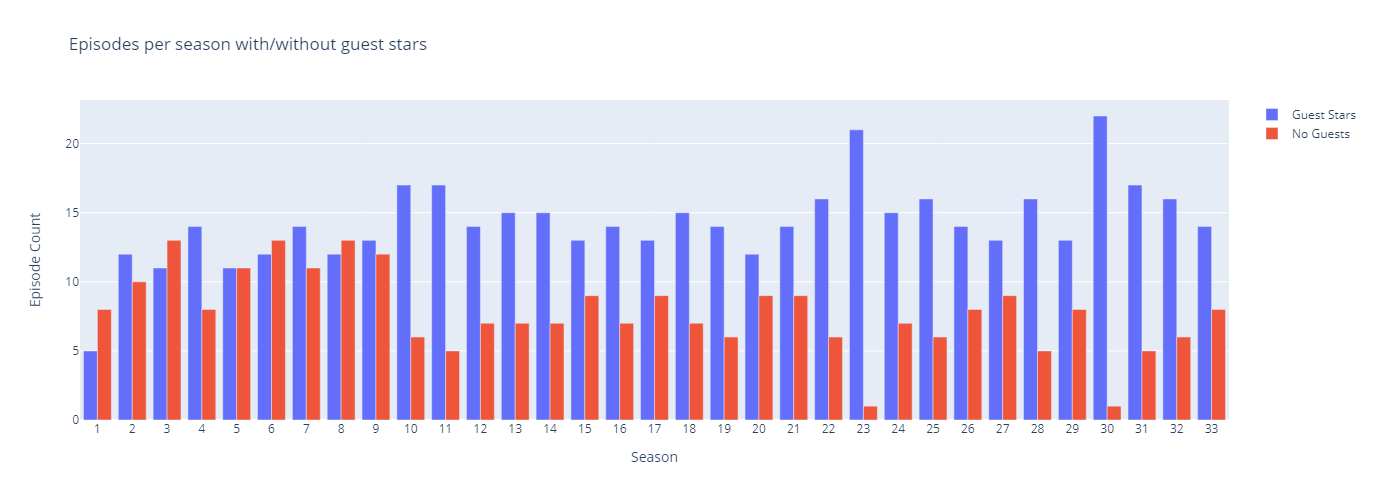

In [25]:
import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Bar(name='Guest Stars', x=simpsons_season.season, y=simpsons_season.guest_flag),
#     go.Bar(name='No Guests', x=simpsons_season.season, y=simpsons_season.ep_count - simpsons_season.guest_flag),
# ])
fig = go.Figure(data=[
    go.Bar(name='Guest Stars', x=simpsons_season.season, y=simpsons_season.guest_flag),
    go.Bar(name='No Guests', x=simpsons_season.season, y=simpsons_season.ep_count - simpsons_season.guest_flag),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='Episode Count',
    title='Episodes per season with/without guest stars'
)
fig.show()

## Average comparison of Guest/No-guests

In [26]:
guest_episodes = simpsons_episodes[simpsons_episodes.guest_flag == 1]
no_guest_episodes = simpsons_episodes[simpsons_episodes.guest_flag == 0]

In [27]:
agg_functions = {'season': 'first', 'rating': 'mean', 'viewers': 'mean',
                 'As_Themselves': 'sum', 'Character_Played': 'sum', 'guest': 'mean',
                 'Homer_main': 'mean', 'Marge_main': 'mean', 'Bart_main': 'mean',
                 'Lisa_main': 'mean', 'Maggie_main': 'mean', 'guest_flag': 'sum',
                'ep_count': 'sum'}
guest_season = guest_episodes.groupby(guest_episodes['season']).aggregate(agg_functions)

guest_season.rating = guest_season.rating.round(2)
guest_season.viewers = guest_season.viewers.round(2)

In [28]:
agg_functions = {'season': 'first', 'rating': 'mean', 'viewers': 'mean',
                 'As_Themselves': 'sum', 'Character_Played': 'sum', 'guest': 'mean',
                 'Homer_main': 'mean', 'Marge_main': 'mean', 'Bart_main': 'mean',
                 'Lisa_main': 'mean', 'Maggie_main': 'mean', 'guest_flag': 'sum',
                'ep_count': 'sum'}
no_guest_season = no_guest_episodes.groupby(no_guest_episodes['season']).aggregate(agg_functions)

no_guest_season.rating = no_guest_season.rating.round(2)
no_guest_season.viewers = no_guest_season.viewers.round(2)

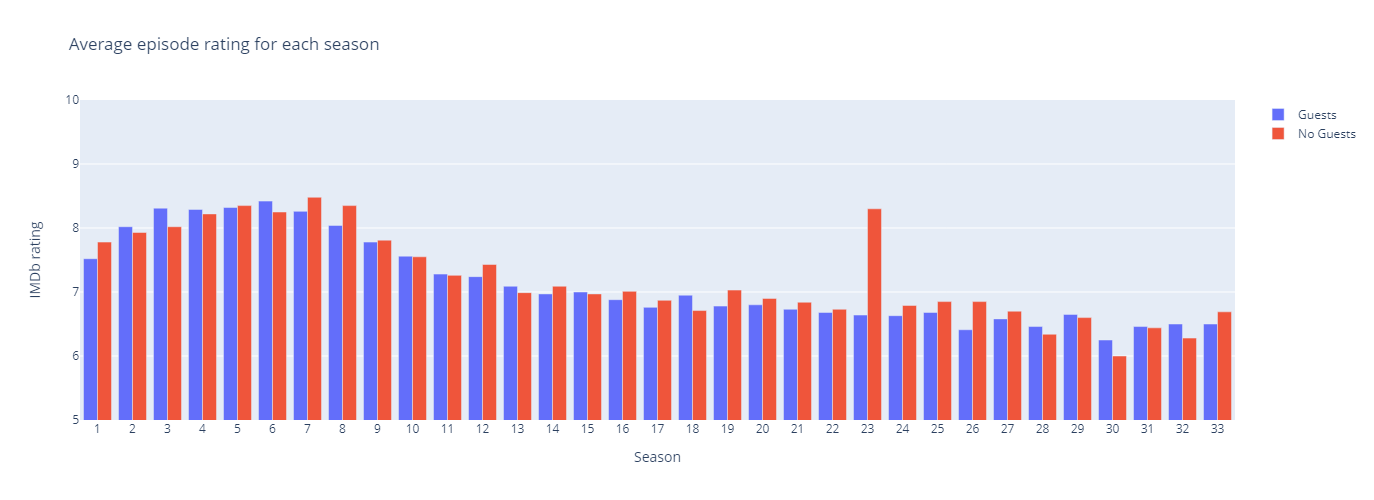

In [29]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guests', x=guest_season.season, y=guest_season.rating),
    go.Bar(name='No Guests', x=no_guest_season.season, y=no_guest_season.rating),
])
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
#fig.update_xaxes(range=[20.5, 33.5], tick0=1, dtick=1)
fig.update_yaxes(range=[5, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='IMDb rating',
    title='Average episode rating for each season'
)
fig.show()

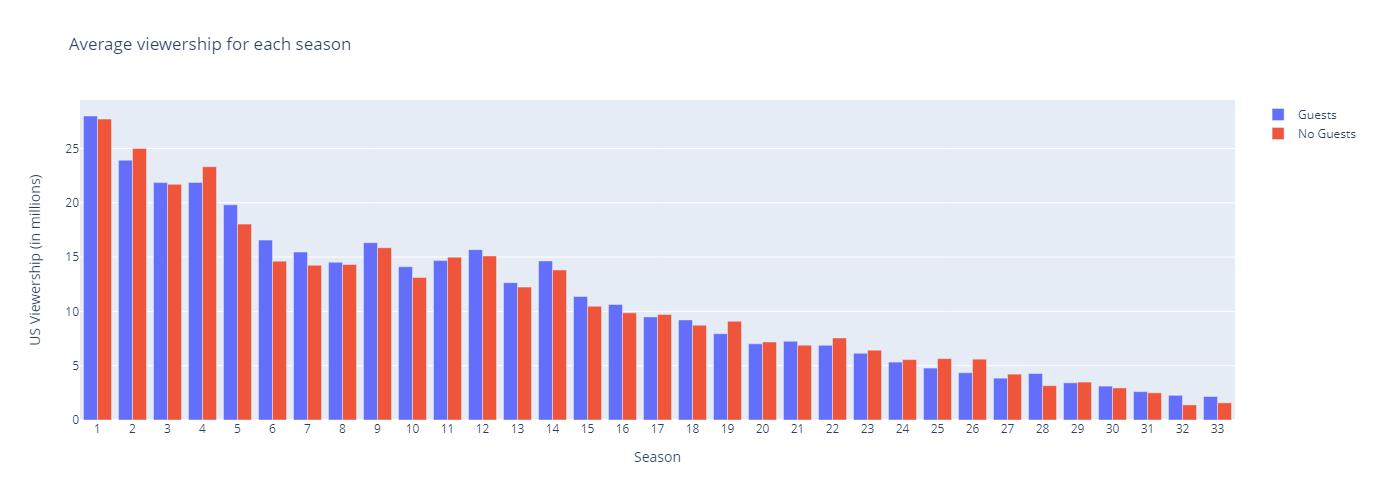

In [30]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guests', x=guest_season.season, y=guest_season.viewers),
    go.Bar(name='No Guests', x=no_guest_season.season, y=no_guest_season.viewers),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 33.5], tick0=1, dtick=1)
#fig.update_xaxes(range=[19.5, 33.5], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Season',
    yaxis_title='US Viewership (in millions)',
    title='Average viewership for each season'
)
fig.show()

## Picking a single season and looking at how Guests affect individual episodes

In [33]:
season_8 = simpsons_episodes[simpsons_episodes.season == 8]
season_9 = simpsons_episodes[simpsons_episodes.season == 9]

In [34]:
season_8.head()

season  episode                    title    airdate  rating  total_votes  \
153       8        1  Treehouse of Horror VII 1996-11-03     8.4         3300   
154       8        2      You Only Move Twice 1997-01-05     9.2         6200   
155       8        3      The Homer They Fall 1996-11-24     8.1         2900   
156       8        4        Burns, Baby Burns 1996-12-29     7.6         2800   
157       8        5          Bart After Dark 1997-01-19     8.3         3000   

                                                  desc              director  \
153  Bart's Siamese twin swells in the attic; Lisa'...  [, Mike B. Anderson]   
154  The Simpsons move to Cypress Creek, where Home...    [Mike B. Anderson]   
155  Homer becomes a boxer after Moe discovers his ...       [Mark Kirkland]   
156  The Simpsons try to reunite Mr. Burns with Lar...         [Jim Reardon]   
157  Marge leads a crusade against a local burlesqu...     [Dominic Polcino]   

                                        writer prod_code  ...  Bart_main  \
153  [Dan Greaney, David X. Cohen, Ken Keeler]      4F02  ...          1   
154                        [John Swartzwelder]      3F23  ...          0   
155                         [Jonathan Collier]      4F03  ...          0   
156                       [Ian Maxtone-Graham]      4F05  ...          0   
157                            [Richard Appel]      4F06  ...          1   

     Lisa_main  Maggie_main  Treehouse  rating_group  votes_k  \
153          1            0          1             2      3.3   
154          0            0          0             1      6.2   
155          0            0          0             2      2.9   
156          0            0          0             2      2.8   
157          0            0          0             2      3.0   

         date_format  guest  guest_flag  ep_count  
153  Sun 03 Nov 1996      0           0         1  
154  Sun 05 Jan 1997      0           0         1  
155  Sun 24 Nov 1996      2           1         1  
156  Sun 29 Dec 1996      1           1         1  
157  Sun 19 Jan 1997      0           0         1  

[5 rows x 26 columns]

In [35]:
season_8_guests = season_8[season_8.guest_flag == 1]
season_8_no_guests = season_8[season_8.guest_flag == 0]

season_9_guests = season_9[season_9.guest_flag == 1]
season_9_no_guests = season_9[season_9.guest_flag == 0]

## Season 8

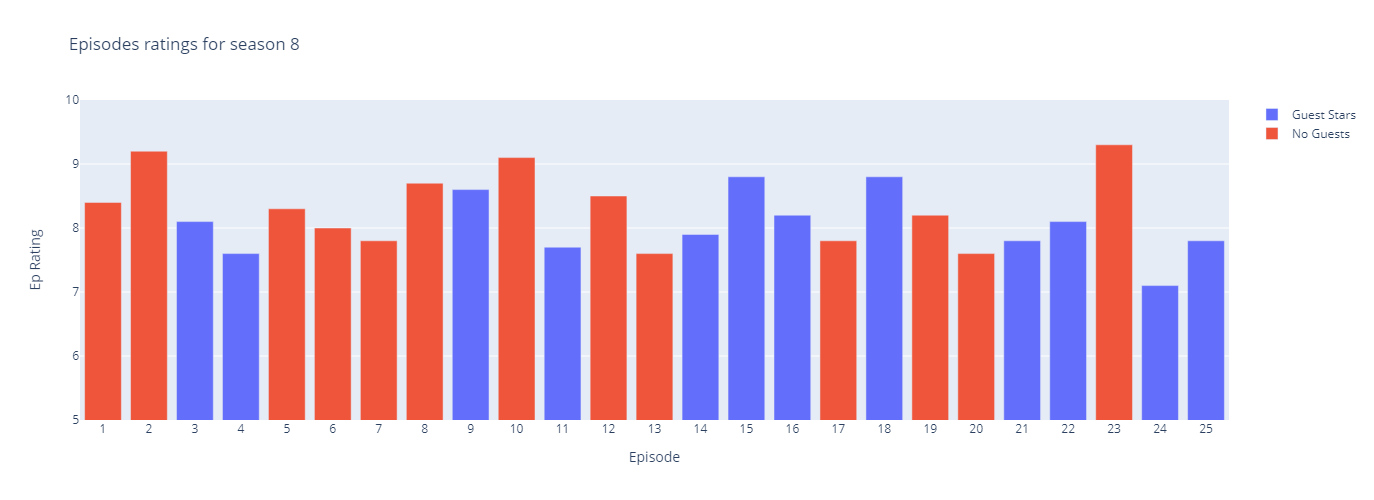

In [42]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guest Stars', x=season_8_guests.episode, y=season_8_guests.rating),
    go.Bar(name='No Guests', x=season_8_no_guests.episode, y=season_8_no_guests.rating),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 25.5], tick0=1, dtick=1)
fig.update_yaxes(range=[5, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Episode',
    yaxis_title='Ep Rating',
    title='Episodes ratings for season 8'
)
fig.show()

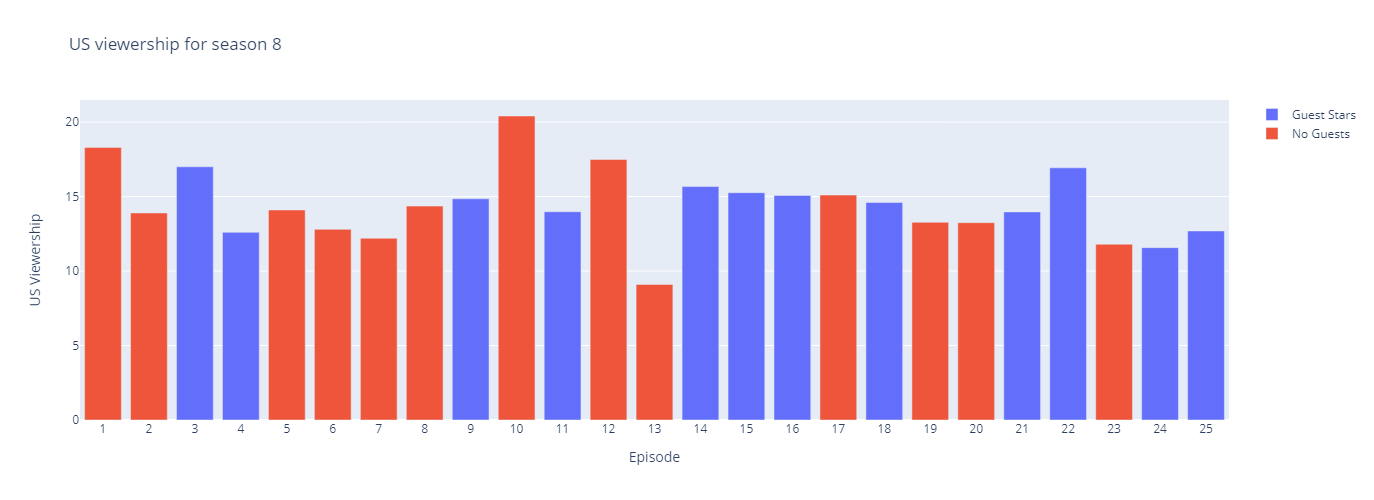

In [48]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guest Stars', x=season_8_guests.episode, y=season_8_guests.viewers),
    go.Bar(name='No Guests', x=season_8_no_guests.episode, y=season_8_no_guests.viewers),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 25.5], tick0=1, dtick=1)
#fig.update_yaxes(range=[5, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Episode',
    yaxis_title='US Viewership',
    title='US viewership for season 8'
)
fig.show()

## Season 9

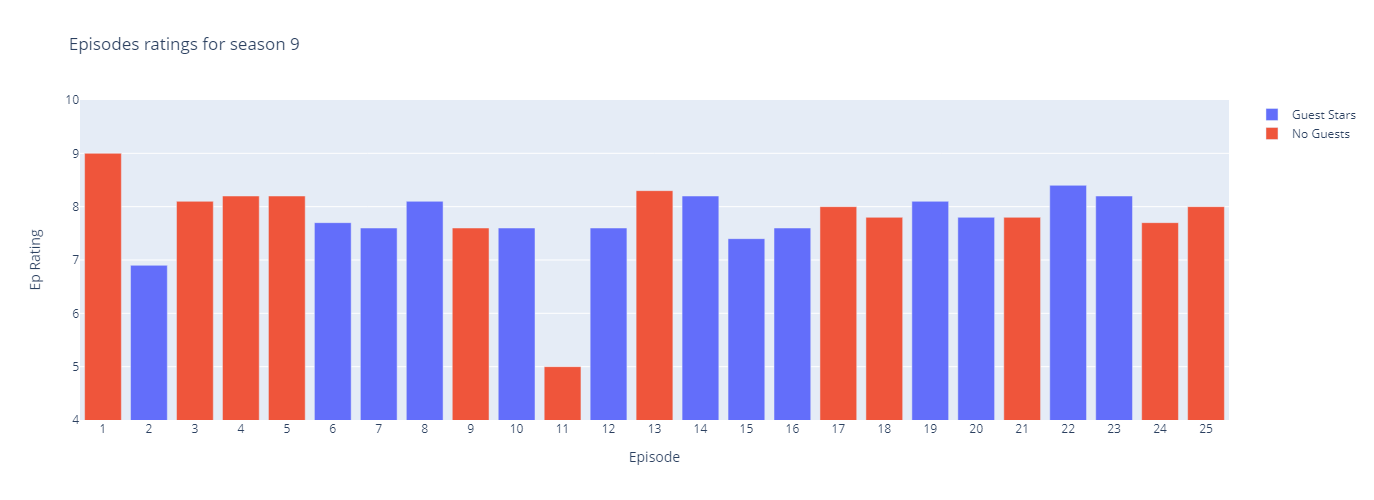

In [44]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guest Stars', x=season_9_guests.episode, y=season_9_guests.rating),
    go.Bar(name='No Guests', x=season_9_no_guests.episode, y=season_9_no_guests.rating),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 25.5], tick0=1, dtick=1)
fig.update_yaxes(range=[4, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Episode',
    yaxis_title='Ep Rating',
    title='Episodes ratings for season 9'
)
fig.show()

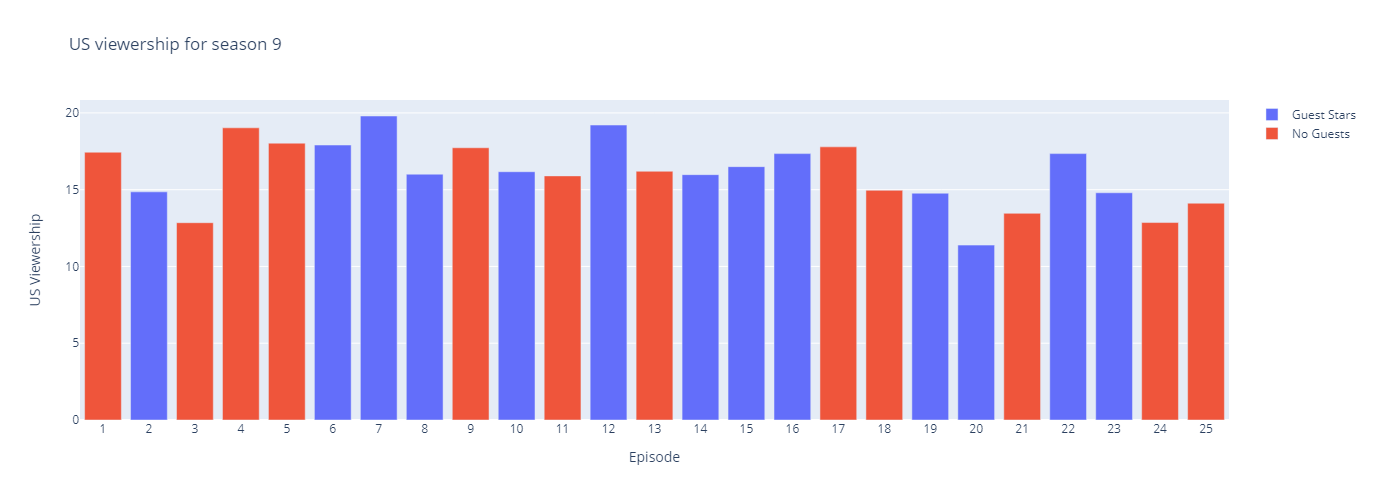

In [49]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Guest Stars', x=season_9_guests.episode, y=season_9_guests.viewers),
    go.Bar(name='No Guests', x=season_9_no_guests.episode, y=season_9_no_guests.viewers),
])
# Change the bar mode
#fig.update_layout(barmode='stack')
fig.update_xaxes(range=[0.5, 25.5], tick0=1, dtick=1)
#fig.update_yaxes(range=[5, 10], tick0=1, dtick=1)
fig.update_layout(
    width=1300,
    height=500,
    xaxis_title='Episode',
    yaxis_title='US Viewership',
    title='US viewership for season 9'
)
fig.show()

# Features Characters

What is the average rating/viewership for each characters episodes? And what is the Standard Deviation of this?